# Monte Carlo SVG (unbiased)

In this notebook we aim to answer the following questions, asked in last week's [report](https://wandb.ai/angelovtt/LQG-SVG/reports/Apr-15-Project-Update--Vmlldzo2MTE3NzA).
> What's the gradient error and variance incurred by approximating SVG formulations (1,2) via Monte Carlo? (using the true model, reward, and value function) 
How does it scale with the sample regime?

---
## Setup

In [1]:
from __future__ import annotations

### Environment

We sample a single LQG for this experiment

In [2]:
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import LQGGenerator
from lqsvg.envs.lqr.modules import (
    InitStateDynamics,
    LinearDynamicsModule,
    LQGModule,
    QuadraticReward,
)

In [3]:
generator = LQGGenerator(
    n_state=2,
    n_ctrl=2,
    horizon=20,
    stationary=True,
    passive_eigval_range=(0.5, 1.5),
    controllable=True,
    seed=32,
)

In [4]:
def make_lqg_module() -> LQGModule:
    dynamics, cost, init = generator()
    return LQGModule(
        (generator.n_state, generator.n_ctrl, generator.horizon),
        LinearDynamicsModule(dynamics, stationary=generator.stationary),
        QuadraticReward(cost),
        InitStateDynamics(init),
    )

In [5]:
make_lqg_module()

/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-kEsPsxvA-py3.8/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:934.)
  return super(Tensor, self).refine_names(names)


### Policy

We use a _stabilizing_ policy generated as described in "[Generating stabilizing policies](https://wandb.ai/angelovtt/LQG-SVG/reports/Apr-9-Project-Update--Vmlldzo1OTYxNTI#generating-stabilizing-policies)".

In [6]:
from lqsvg.policy.modules import TVLinearPolicy

In [7]:
def make_stabilizing_policy(module: LQGModule) -> TVLinearPolicy:
    policy = TVLinearPolicy(module.n_state, module.n_ctrl, module.horizon)
    policy.stabilize_(module.trans.standard_form())
    return policy

In [8]:
make_stabilizing_policy(make_lqg_module())

---
## Ground-truth policy gradient

In [9]:
from lqsvg.experiment.estimators import AnalyticSVG

In [10]:
def test_analytic():
    lqg_nn = make_lqg_module()
    policy_nn = make_stabilizing_policy(lqg_nn)
    return AnalyticSVG(policy_nn, lqg_nn)()

In [ ]:
test_analytic()

In [11]:
import textwrap

In [12]:
def print_val_svg(value, svg):
    msg = f"""\
    Shape: 
    - value: {value.shape}
    - dynamic gradient: {svg[0].shape}
    - static gradient: {svg[1].shape}
    Max/Min:
    - dynamic gradient: {svg[0].max()}/{svg[0].min()}
    - static gradient: {svg[1].max()}/{svg[1].min()}
    StdDev:
    - dynamic gradient: {svg[0].std()}
    - static gradient: {svg[1].std()}"""
    print(textwrap.dedent(msg))

In [13]:
print_val_svg(*test_analytic())

Shape: 
- value: torch.Size([])
- dynamic gradient: torch.Size([20, 2, 2])
- static gradient: torch.Size([20, 2])
Max/Min:
- dynamic gradient: 2.934584140777588/-0.2167457640171051
- static gradient: 0.0/0.0
StdDev:
- dynamic gradient: 1.033557653427124
- static gradient: 0.0


---
## Approximating (1) with samples

Recall the first SVG formulation discussed in the report:
$$
\nabla J(\theta) = \mathbb{E}_{\mathbf{s}_0 \sim \rho} \left[ \nabla_\theta V^{\mu_\theta}(\mathbf{s}_0) \right]. \qquad (1)
$$

In [14]:
from lqsvg.experiment.estimators import MonteCarloSVG

In [17]:
def test_mc_svg():
    lqg_nn = make_lqg_module()
    policy_nn = make_stabilizing_policy(lqg_nn)
    mc_estimator = MonteCarloSVG(policy_nn, lqg_nn)
    mc_value, mc_svg = mc_estimator(samples=10)
    print_val_svg(mc_value, mc_svg)

In [ ]:
test_mc_svg()

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm, trange

sns.set()

In [19]:
import lqsvg.experiment.analysis as analysis
import lqsvg.experiment.utils as exp_util

In [20]:
def grad_estimates(
    estimator: MonteCarloSVG, sample_sizes: list[int], estimates_per_sample_size: int = 10
) -> list[list[lqr.Linear]]:
    svgs_by_sample_size = []
    for size in tqdm(sample_sizes, desc="Computing cossim by sample size"):
        estimates = [
            estimator(samples=size) for _ in range(estimates_per_sample_size)
        ]
        _, svgs = zip(*estimates)
        svgs_by_sample_size += [svgs]
    return svgs_by_sample_size

In [21]:
def default_figsize(rows: int = 1, cols: int = 1) -> tuple[float, float]:
    default_width, default_height = mpl.rcParams["figure.figsize"]
    return (rows * default_height, cols * default_width)

In [22]:
def plot_mc_quality_vs_samples(estimates_per_sample_size: int = 10):
    lqg_nn = make_lqg_module()
    policy_nn = make_stabilizing_policy(lqg_nn)
    estimator = MonteCarloSVG(policy_nn, lqg_nn)    
    
    sample_sizes = [1 + 10 * i for i in range(10)]
    svgs_by_sample_size = grad_estimates(estimator, sample_sizes, estimates_per_sample_size)

    cossims = [
        analysis.gradient_accuracy(svgs, true_svg) for svgs in svgs_by_sample_size
    ]
    empvars = [analysis.empirical_variance(svgs) for svgs in svgs_by_sample_size]

    x = "#Trajectories"
    gradient_accuracy = "Avg. cos sim with true grad"
    empirical_variance = "Avg. pairwise cos sim"
    data = pd.DataFrame(
        {x: sample_sizes, gradient_accuracy: cossims, empirical_variance: empvars}
    )

    fig = plt.figure(figsize=default_figsize(2, 1))
    ax = fig.add_subplot(2, 1, 1)
    sns.lineplot(ax=ax, x=x, y=gradient_accuracy, data=data, ci="std")
    ax.set_xlabel(None)
    ax = fig.add_subplot(2, 1, 2)
    sns.lineplot(ax=ax, x=x, y=empirical_variance, data=data, ci="std")
    plt.show()

Computing cossim by sample size:   0%|          | 0/10 [00:00<?, ?it/s]

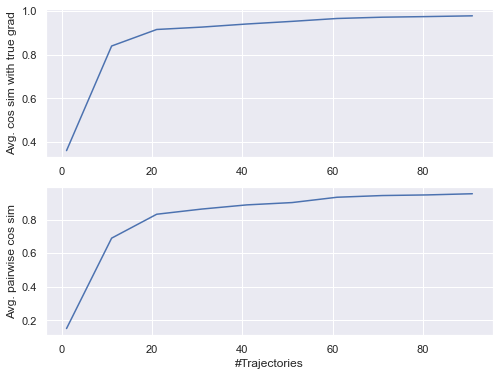

In [23]:
plot_mc_quality_vs_samples()

---
## Approximating (2) with samples

Recall the second SVG formulation discussed in the report:
$$
\nabla J(\theta) = \mathbb{E}_{\mathbf{s}\sim d^{\mu_\theta}} \left[ \nabla_\theta \mu_\theta(\mathbf{s}) \nabla_{\bf a} Q^{\mu_\theta}(\mathbf{s, a}) |_{\bf a = \mu_\theta(s)}\right]. \qquad (2)
$$

In [1]:
from lqsvg.policy.modules import QuadQValue

In [ ]:
def make_qvalue(policy: TVLinearPolicy, model: LQGModule) -> QuadQValue:
    return QuadQValue.from_policy(
        policy.standard_form(),
        model.trans.standard_form(),
        model.reward.standard_form(),
    )

In [ ]:
def starting_states(policy: TVLinearPolicy, model: LQGModule) -> Tensor:
    rollout_module = MonteCarloSVG(policy, model)
    with torch.no_grad():
        obs, _, _, _, _ = rollout_module.rsample_trajectory(torch.Size([1000]))
        
    obs = obs.flatten(["H", "B1"], "B")
    return obs

In [ ]:
from lqsvg.experiment.estimators import BootstrappedSVG

In [ ]:
# Implement class containing boostrapped SVG estimator and obs dataset